In [8]:
import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import seaborn as sns
import os
from tqdm import tqdm
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, BatchNormalization, MaxPooling2D, Input
from keras.models import Model
from sklearn.model_selection import train_test_split

In [2]:
dataset = pd.read_pickle('./stage_1_train_labels_ext')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28989 entries, 0 to 28988
Data columns (total 9 columns):
patientId    28989 non-null object
x            8964 non-null float64
y            8964 non-null float64
width        8964 non-null float64
height       8964 non-null float64
Target       28989 non-null int64
age          28989 non-null int64
vpe          28989 non-null object
sex          28989 non-null object
dtypes: float64(4), int64(2), object(3)
memory usage: 2.2+ MB


In [3]:
xrays = []
compression = (128, 128)
path = './stage_1_train_images/'
for patientId in tqdm(dataset.patientId):
    pds = pydicom.read_file(path + patientId + '.dcm')
    img = Image.fromarray(pds.pixel_array)
    img = img.resize(compression, Image.ANTIALIAS)
    xray = np.array(img)
    xray = xray/255
    xrays.append(xray)
print('Loaded ', len(xrays), ' images')

100%|████████████████████████████████████████████████████████████████████████████| 28989/28989 [09:07<00:00, 52.91it/s]


Loaded  28989  images


In [4]:
xrays = np.array(xrays)
xrays = xrays.reshape((-1, compression[0], compression[1], 1))
xrays.shape

(28989, 128, 128, 1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(xrays, dataset.Target, test_size = 0.2, random_state = 42)

In [10]:
inputs = Input(shape=(compression[0], compression[1], 1))

cnn = Conv2D(64, (4, 4), activation='relu')(inputs)
cnn = MaxPooling2D((3, 3))(cnn)
cnn = BatchNormalization()(cnn)

cnn = GlobalAveragePooling2D()(cnn)

dense = Dense(1, activation='sigmoid')(cnn)

model = Model(inputs=inputs, outputs=dense)

model.compile(loss='binary_crossentropy', metrics = ['accuracy'], optimizer='adam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 64)      1088      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 41, 41, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 41, 41, 64)        256       
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,409
Trainable params: 1,281
Non-trainable params: 128
_________________________________________________________________


In [11]:
training_history = model.fit(X_train, y_train, epochs=5, batch_size=16, validation_data=(X_test, y_test))

Train on 23191 samples, validate on 5798 samples
Epoch 1/5
23191/23191 [==============================] - ETA: 751s - loss: 0.6995 - acc: 0.3125 - ETA: 281s - loss: 0.6887 - acc: 0.5000 - ETA: 188s - loss: 0.6793 - acc: 0.5375 - ETA: 147s - loss: 0.6784 - acc: 0.5536 - ETA: 125s - loss: 0.6847 - acc: 0.5417 - ETA: 110s - loss: 0.6922 - acc: 0.5341 - ETA: 100s - loss: 0.6923 - acc: 0.5481 - ETA: 92s - l

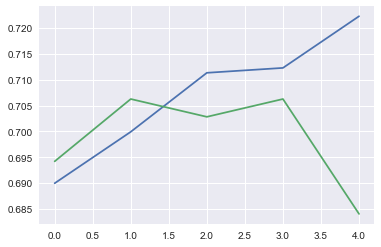

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(training_history.history['acc'])
plt.plot(training_history.history['val_acc'])
plt.show()

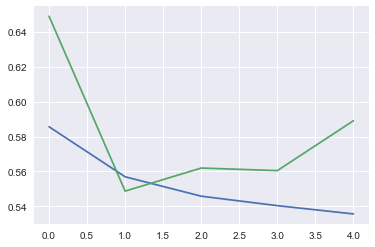

In [14]:
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.show()